**Json Fields** :
   1. ***info*** - file metadata: name, url, date created,description,version,contributer.
   2. ***images***:
        * id - unique id
        * width - image width
        * height - image height
        * file_name - name of the file
        * license   - licence if any
        * date_captured - date when captured
   3. ***annotation*** - contains metrics of the bounding boxes
        * id  - unique id
        * image_id - reference to the image
        * segmentation- Co-Ordinates of the bbox. For rectangle there will be 8 coordinates (4 x,y pairs) - top-left, top-right, bottom-left, bottom-right.
        * area - area of bounding box
        * bbox - 4 points. top-left x-coordinate,top-left y-coordinate, width of bbox, height of bbox 
        * iscrowd - It defines whether there is a single image(iscrowd = 0) or group of objects(iscrowd = 1) 
   4.  licence
   5.  Categories - Each category has 3 sub-fields: id, name, supercategory. 

In [1]:
!git clone https://github.com/swapniel99/ezio.git

Cloning into 'ezio'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 442 (delta 27), reused 63 (delta 16), pack-reused 357
Receiving objects: 100% (442/442), 10.45 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (172/172), done.


In [2]:
%cd ezio

/content/ezio
Branch 'session_12' set up to track remote branch 'session_12' from 'origin'.
Switched to a new branch 'session_12'


In [3]:
import json 
import pandas as pd
  
## Read the json data
data = json.load(open('datasets/yolo_dataset/coco_format.json'))

In [5]:
images_df = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())

In [6]:
images_df.head()

,id,width,height,file_name,license,date_captured
0,1,768,432,image_72.png,0,
1,2,600,421,image_134.jpg,0,
2,3,321,500,image_144.jpg,0,
3,4,1300,947,image_68.jpg,0,
4,5,1300,956,image_90.jpg,0,


In [7]:
annotations.head()

,segmentation,area,bbox,iscrowd,id,image_id,category_id
0,"[[105, -1, 546, -1, 546, 211, 105, 211]]",93492,"[105, -1, 441, 212]",0,1,1,4
1,"[[168, 192, 340, 192, 340, 381, 168, 381]]",32508,"[168, 192, 172, 189]",0,2,1,1
2,"[[244, 25, 363, 25, 363, 104, 244, 104]]",9401,"[244, 25, 119, 79]",0,3,2,4
3,"[[204, 171, 435, 171, 435, 400, 204, 400]]",52899,"[204, 171, 231, 229]",0,4,2,3
4,"[[137, 34, 194, 34, 194, 68, 137, 68]]",1938,"[137, 34, 57, 34]",0,5,3,4


In [8]:
## Preprocess the annotations file
bbox_w = []
bbox_h = []

bbox_list = list(annotations['bbox'])
for bbox in bbox_list:
    bbox_w.append(bbox[2])
    bbox_h.append(bbox[3])


annotate_df = pd.DataFrame(list(zip(bbox_w, bbox_h)), columns =['bbox_w', 'bbox_h'])
annotate_df['id'] = annotations['image_id']
annotate_df.head()

,bbox_w,bbox_h,id
0,441,212,1
1,172,189,1
2,119,79,2
3,231,229,2
4,57,34,3


In [9]:
## Concat the two files
final_df = pd.merge(images_df[['width','height','file_name','id']], annotate_df, on='id')
final_df.head()

,width,height,file_name,id,bbox_w,bbox_h
0,768,432,image_72.png,1,441,212
1,768,432,image_72.png,1,172,189
2,600,421,image_134.jpg,2,119,79
3,600,421,image_134.jpg,2,231,229
4,321,500,image_144.jpg,3,57,34


In [11]:
## Normalize the parameters
final_df['bbox_w'] = final_df['bbox_w']/final_df['width']
final_df['bbox_h'] = final_df['bbox_h']/final_df['height']

final_df = final_df[['bbox_w','bbox_h']]
final_df = final_df.dropna()

In [12]:
print(final_df.shape)
final_df.head()

(343, 2)


,bbox_w,bbox_h
0,0.574219,0.490741
1,0.223958,0.437500
2,0.198333,0.187648
3,0.385000,0.543943
4,0.177570,0.068000


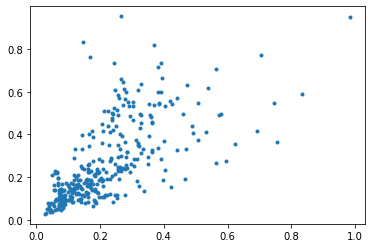

In [13]:
## Visualize the data
import matplotlib.pyplot as plt
plt.plot(final_df['bbox_w'],final_df['bbox_h'], '.')

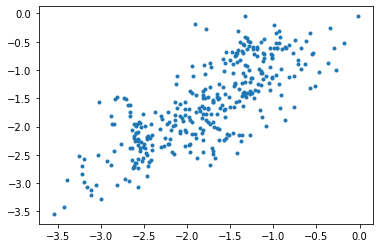

In [14]:
## Plot the log of the data points
import numpy as np
plt.plot(np.log(final_df['bbox_w']),np.log(final_df['bbox_h']), '.')

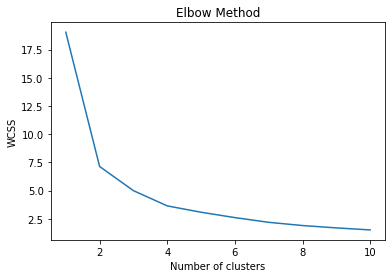

In [15]:
## Elbow method
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(final_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Optimal Number of Clusters : 4

In [16]:
import numpy as np
array_points = np.array(final_df)

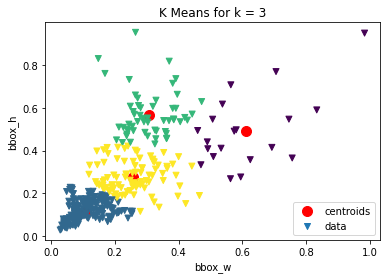

In [17]:
model = KMeans(4)
model.fit(array_points)

plt.scatter(model.cluster_centers_[:,0] ,model.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(final_df['bbox_w']), list(final_df['bbox_h']), marker="v",c=list(model.labels_.astype(float)), label = "data")
plt.legend()
plt.xlabel('bbox_w')
plt.ylabel('bbox_h')
plt.title('K Means for k = 3')
plt.legend()
plt.show()